In [57]:
# initialize dependencies
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms
import random

torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


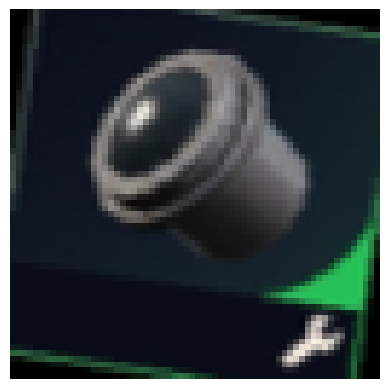

In [58]:
# prepare datasets
# import png images from 'arc-raiders-items' folder. Label is folder name, images below are training images.
train_dataset = torchvision.datasets.ImageFolder(
    root="./arc-raiders-items",
    transform=transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    ),
)
train_dataset_gpu = [(image.to(device), label) for image, label in train_dataset]

# display random image from dataset to ensure it has loaded properly
index = random.randrange(0, len(train_dataset) - 1)
image, label = train_dataset_gpu[index]

import matplotlib.pyplot as plt
plt.imshow(torch.Tensor(image).cpu().permute(1, 2, 0))  # change from CxHxW to HxWxC
plt.axis("off")
plt.show()


In [60]:
# init neuralnet
net = nn.Sequential(
    nn.Flatten(), # flatten image to 1d vector
    nn.Linear(64 * 64 * 3, 128), # input layer -> 128 neuron hidden layer
    nn.ReLU(), # activation
    nn.Dropout(0.15), # dropout for robustness i think
    nn.Linear(128, len(train_dataset)), # output layer -> number of classes (categories of images)
).cuda()  # move model to GPU if available

loss_fn = nn.CrossEntropyLoss() # standard loss function for multi-class classification
optimizer = torch.optim.Adam(net.parameters(), lr=0.00004) # Adam optimizer with low learning rate

In [61]:
# training loop

num_epochs = 100
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset_gpu, batch_size=batch_size, shuffle=True,
    generator=torch.Generator(device="cuda" if torch.cuda.is_available() else "cpu")
)

for epoch in range(num_epochs):
    for images, labels in train_loader:

        # forward pass (make a prediction)
        logits = net(images)
        loss = loss_fn(logits, labels)

        # good old fashioned back propogation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# set model to eval mode
net.eval()

Epoch [1/100], Loss: 6.1623
Epoch [2/100], Loss: 5.2264
Epoch [3/100], Loss: 4.9163
Epoch [4/100], Loss: 4.6554
Epoch [5/100], Loss: 4.3053
Epoch [6/100], Loss: 3.8392
Epoch [7/100], Loss: 3.7274
Epoch [8/100], Loss: 3.4630
Epoch [9/100], Loss: 3.2621
Epoch [10/100], Loss: 2.7616
Epoch [11/100], Loss: 2.6002
Epoch [12/100], Loss: 2.3967
Epoch [13/100], Loss: 2.1421
Epoch [14/100], Loss: 2.0399
Epoch [15/100], Loss: 1.9612
Epoch [16/100], Loss: 1.5951
Epoch [17/100], Loss: 1.2267
Epoch [18/100], Loss: 1.2942
Epoch [19/100], Loss: 1.1445
Epoch [20/100], Loss: 0.9302
Epoch [21/100], Loss: 1.0636
Epoch [22/100], Loss: 1.0833
Epoch [23/100], Loss: 0.7814
Epoch [24/100], Loss: 0.6736
Epoch [25/100], Loss: 0.5091
Epoch [26/100], Loss: 0.6368
Epoch [27/100], Loss: 0.4099
Epoch [28/100], Loss: 0.5269
Epoch [29/100], Loss: 0.4156
Epoch [30/100], Loss: 0.4748
Epoch [31/100], Loss: 0.3885
Epoch [32/100], Loss: 0.2783
Epoch [33/100], Loss: 0.4063
Epoch [34/100], Loss: 0.2052
Epoch [35/100], Loss: 0

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=128, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.15, inplace=False)
  (4): Linear(in_features=128, out_features=19190, bias=True)
)

# mostly util stuff below this

Predicted: [73, 106, 120, 55, 183], Actual: [73, 106, 120, 55, 183]


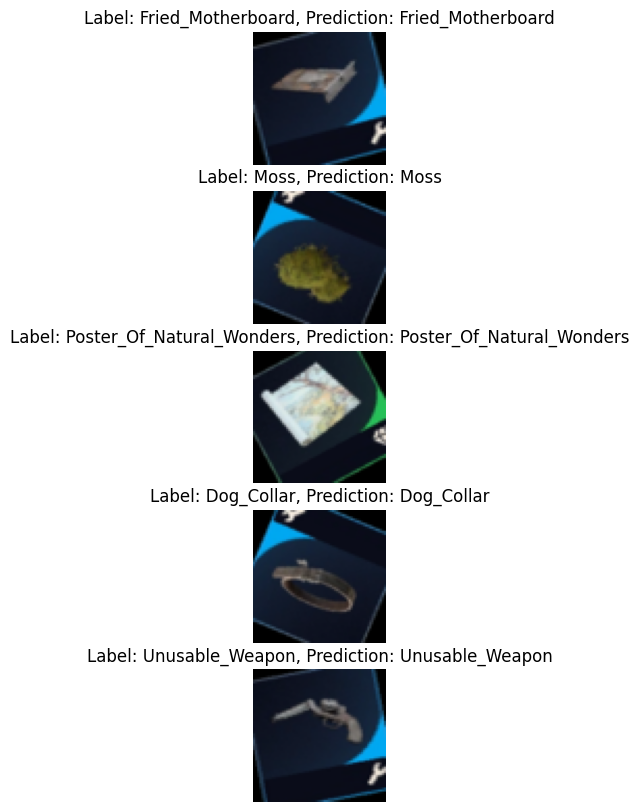

In [63]:
# predict on random images
# select random image set and predict
randomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
images = []
labels = []
for i in range(5):
    img, lbl = train_dataset[randomIndices[i]]
    images.append(img)
    labels.append(lbl)

# infer on GPU

images = torch.stack(images).to(device)  # create batch
logits = net(images)
predicted_labels = logits.argmax(dim=1).tolist()

# Get class names from ImageFolder
dataset_classes = torchvision.datasets.ImageFolder(root="./arc-raiders-items").classes

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {predicted_labels}, Actual: {labels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[randomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")

In [ ]:
import copy

# Save neural net weights
torch.save(net.state_dict(), "arcraiders_model.pth")

device = torch.device("cpu")

# save ONNX
dummy_input = torch.randn(1, 3, 64, 64)
torch.onnx.export(net, dummy_input, "arcraiders_model.onnx", opset_version=17, do_constant_folding=True)

[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.1+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,64,64]>
            ),
            outputs=(
                %"linear_1"<FLOAT,[1,19190]>
            ),
            initializers=(
                %"1.weight"<FLOAT,[128,12288]>{TorchTensor(...)},
                %"1.bias"<FLOAT,[128]>{TorchTensor(...)},
                %"4.weight"<FLOAT,[19190,128]>{TorchTensor(...)},
                %"4.bias"<FLOAT,[19190]>{TorchTensor(...)},
                %"val_3"<INT64,[2]>{Tensor<INT64,[2]>(array([    1, 12288]), name='val_3')}
            ),
        ) {
            0 |  # node_view
                 %"view"<FLOAT,[1,12288]> ⬅️ ::Reshape(%"input", %"val_3"{[1, 12288]}) {allowzero=1}
            1 |  # node

CPU inference time: 0.014343 seconds
Predicted: [158, 130, 130, 183, 9], Actual: [158, 130, 130, 183, 9]


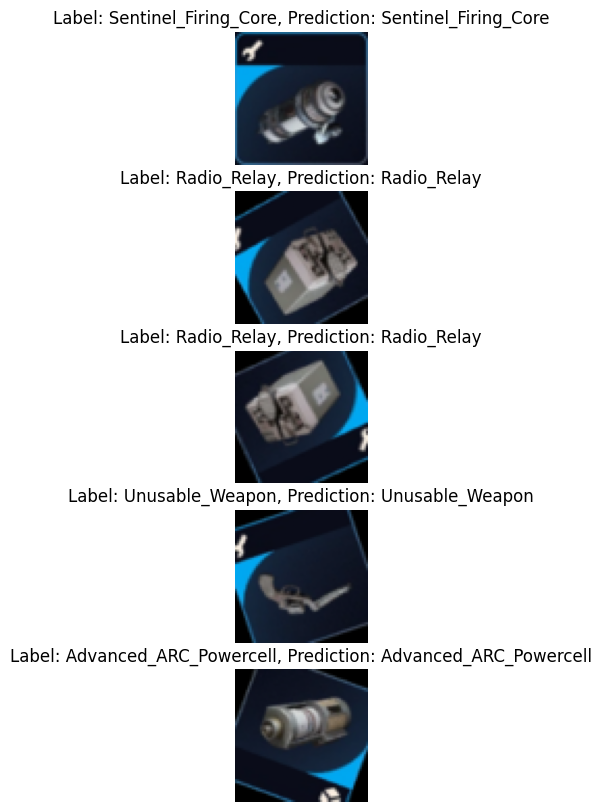

In [45]:
# test CPU inference speed
import time

# import net from file init datasets
if cpu_net is None:
    cpu_net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64 * 64 * 3, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, len(dataset_classes)),
    )
    cpu_net.load_state_dict(torch.load("arcraiders_model.pth"))
    cpu_net.to("cpu")

# prepare random input
cpuRandomIndices = [random.randrange(0, len(train_dataset)) for _ in range(5)]
cpuImages = []
cpuLabels = []
for i in range(5):
    img, lbl = train_dataset[cpuRandomIndices[i]]
    cpuImages.append(img)
    cpuLabels.append(lbl)

random_input = torch.stack(cpuImages)  # create batch
# warm up
_ = cpu_net(random_input)
# measure time
start_time = time.time()
_ = cpu_net(random_input)
end_time = time.time()
print(f"CPU inference time: {end_time - start_time:.6f} seconds")

# infer on GPU

cpuImages = torch.stack(cpuImages) # create batch
cpuLogits = net(cpuImages)
cpu_predicted_labels = cpuLogits.argmax(dim=1).tolist()

# visualise predictions
fig, axes = plt.subplots(5, 1, figsize=(10, 10))
print(f"Predicted: {cpu_predicted_labels}, Actual: {cpuLabels}")
cnt = 0
for ax in axes:
    img, lbl = train_dataset[cpuRandomIndices[cnt]]
    cnt += 1
    ax.imshow(img.permute(1, 2, 0).cpu())  # change from CxHxW to HxWxC
    # convert labels to category names
    train_label_name = dataset_classes[lbl]
    predicted_label_name = dataset_classes[cpu_predicted_labels[cnt-1]]
    ax.set_title(f"Label: {train_label_name}, Prediction: {predicted_label_name}")
    ax.axis("off")